# Proyek  Forecasting Superstore: Superstore Sales Dataset
- **Nama:** [Cindy Alya Putri]
- **NIM:** [22533644]


## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import kagglehub
from kagglehub import KaggleDatasetAdapter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
warnings.filterwarnings("ignore")

## Data Preparation

### Data Loading

In [ ]:
file_path = "train.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rohitsahoo/sales-forecasting",
    file_path
)


### Data Preprocessing

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)


In [ ]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()


In [ ]:
monthly_sales.set_index('Order Date', inplace=True)
monthly_sales = monthly_sales.asfreq('M')

In [ ]:
print(monthly_sales.head())

                Sales
Order Date           
2015-01-31  14205.707
2015-02-28   4519.892
2015-03-31  55205.797
2015-04-30  27906.855
2015-05-31  23644.303


#### Split Dataset

In [ ]:
train = monthly_sales[:'2016']
test = monthly_sales['2017':]

## Modelling

### Model SARIMAX

####Training

In [ ]:
model_sarimax = SARIMAX(train,
                        order=(1,1,1),
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_sarimax = model_sarimax.fit(disp=False)


#### Forecasting

In [ ]:
forecast_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
forecast_sarimax = pd.Series(forecast_sarimax, index=test.index)

#### Metrik Evaluasi

In [ ]:
rmse_sarimax = np.sqrt(mean_squared_error(test, forecast_sarimax))
mae_sarimax = mean_absolute_error(test, forecast_sarimax)

print(f"[SARIMAX] RMSE: {rmse_sarimax:.2f}")
print(f"[SARIMAX] MAE: {mae_sarimax:.2f}")

[SARIMAX] RMSE: 18879.33
[SARIMAX] MAE: 15193.89


### Model XGBOOOST

#### Fitur Waktu

In [ ]:
monthly_sales_ml = monthly_sales.copy()
monthly_sales_ml['month'] = monthly_sales_ml.index.month
monthly_sales_ml['year'] = monthly_sales_ml.index.year


#### Split ulang

In [ ]:
X = monthly_sales_ml[['month', 'year']]
y = monthly_sales_ml['Sales']
X_train, X_test = X[:'2016'], X['2017':]
y_train, y_test = y[:'2016'], y['2017':]

#### Modelling

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
forecast_xgb = model_xgb.predict(X_test)

#### Metrik Evaluasi

In [ ]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, forecast_xgb))
mae_xgb = mean_absolute_error(y_test, forecast_xgb)
print(f"[XGBoost] RMSE: {rmse_xgb:.2f}")
print(f"[XGBoost] MAE: {mae_xgb:.2f}")

[XGBoost] RMSE: 21057.55
[XGBoost] MAE: 17317.37


## Evaluasi dan Visualisasi

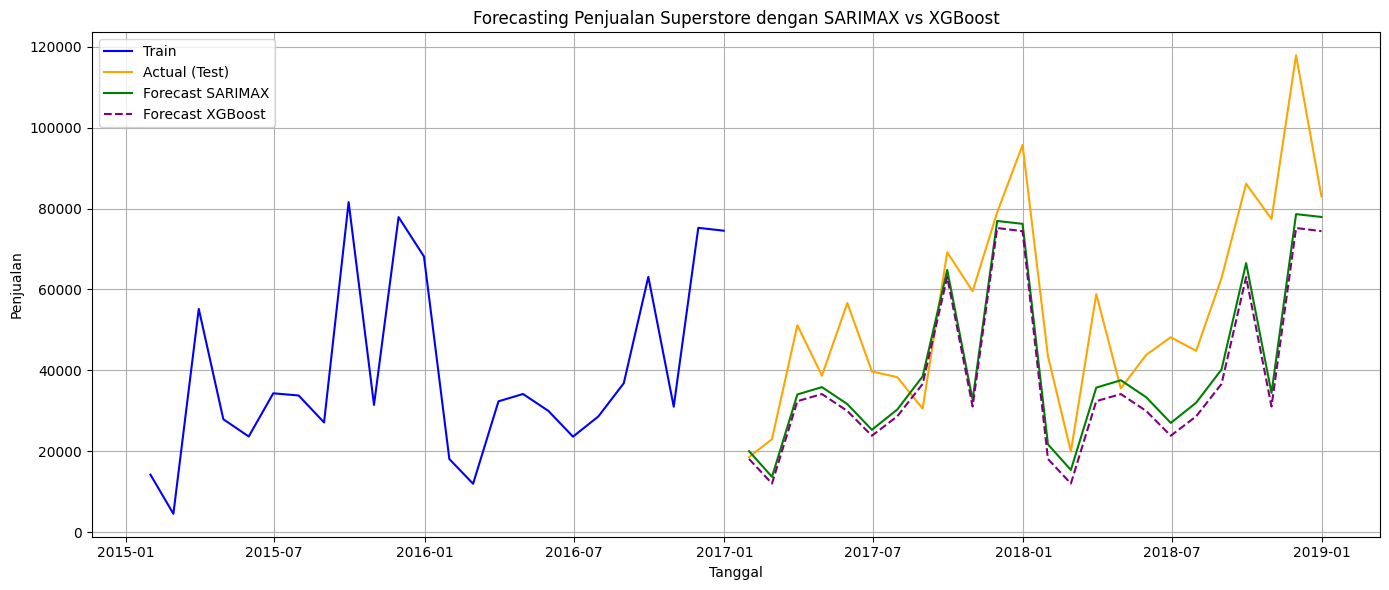

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Sales'], label='Train', color='blue')
plt.plot(test.index, test['Sales'], label='Actual (Test)', color='orange')
plt.plot(test.index, forecast_sarimax, label='Forecast SARIMAX', color='green')
plt.plot(test.index, forecast_xgb, label='Forecast XGBoost', color='purple', linestyle='--')
plt.title('Forecasting Penjualan Superstore dengan SARIMAX vs XGBoost')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()